# Boundary value problems with FFT

In class, we saw a couple of methods to approximate BVPs using FFTs. Let's try them out now. Our model problem will be the Poisson equation

\begin{align}
\frac{\partial^2 u}{\partial x^2} = e^{4x}\\
u(-1) = u(1) = 0
\end{align}

which corresponds to *Program 13* of Trefethen's *Spectral Methods in Matlab*. The analytical solution to this problem is

\begin{equation}
u(x) = \frac{1}{16}\left(e^{4x} - \sinh(4)\cdot x - \cosh(4)\right)
\end{equation}

## Finite difference and FFTs

Discretizing the above equation with finite differences for $N$ nodes, we get

\begin{equation}
\frac{u_{n-1}-2u_n+u_{n+1}}{h^2} = e^{4x_n} = f(x)
\end{equation}

Representing $u_n$ in a Fourier expansion

\begin{equation}
u_n = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} U_k e^\frac{i2\pi kn}{N}
\end{equation}

we can rewrite $u_{n+1}$ and $u_{n-1}$ as

\begin{align}
u_{n+1} = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} U_k e^\frac{i2\pi kn}{N} e^\frac{i2\pi k}{N}\\
u_{n-1} = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} U_k e^\frac{i2\pi kn}{N} e^{-\frac{i2\pi k}{N}}.
\end{align}

and also,

\begin{equation}
f_n = \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} F_k e^\frac{i2\pi kn}{N}
\end{equation}

Replacing these expressions in the discretized equation and factorizing, we get

\begin{equation}
\sum_{k=-\frac{N}{2}+1}^\frac{N}{2}\left[ U_k e^\frac{i2\pi kn}{N} \left( e^\frac{i2\pi k}{N} - 2 + e^{-\frac{i2\pi k}{N}} \right) \right] = h^2 \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} F_k e^\frac{i2\pi kn}{N}
\end{equation}

But

\begin{equation}
 e^\frac{i2\pi k}{N} + e^{-\frac{i2\pi k}{N}} = 2\cos\left(\frac{2\pi k}{N}\right)
\end{equation}

which makes the previous expression 

\begin{equation}
\sum_{k=-\frac{N}{2}+1}^\frac{N}{2}\left[ U_k e^\frac{i2\pi kn}{N} 2\left( \cos\left(\frac{2\pi k}{N}\right) - 1 \right) \right] = h^2 \sum_{k=-\frac{N}{2}+1}^\frac{N}{2} F_k e^\frac{i2\pi kn}{N}
\end{equation}

Then, for each $k$

\begin{align}
2U_k & \left( \cos\left(\frac{2\pi k}{N}\right) - 1 \right) = h^2 F_k\\
\Rightarrow U_k &= \frac{h^2 F_k}{2\left( \cos\left(\frac{2\pi k}{N}\right) - 1 \right)}
\end{align}

and we can obtain $u(x)$ with an inverse FFT. Let's try this out!

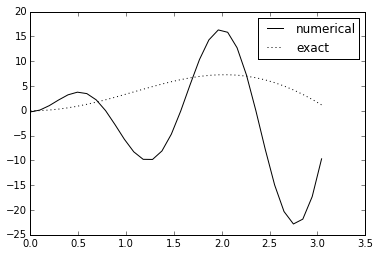

In [61]:
import numpy
import numpy.fft
import scipy.fftpack
from matplotlib import pyplot
%matplotlib inline

N = 32

xmin = 0.#-1.
xmax = numpy.pi#1.

h = (xmax-xmin)/(N)

x = numpy.linspace(xmin, xmax, N, endpoint=False)

#f = numpy.exp(4*x)
f = 4*x*numpy.sin(4*x) - numpy.cos(4*x)

#F_k = numpy.fft.fft(f)
F_k = scipy.fftpack.dst(f, type=1)

k = numpy.arange(N)

#U_k = h**2*F_k/(2*(numpy.cos(2*numpy.pi*k/N)-1))
U_k = h**2*F_k/(2*(1-numpy.cos(numpy.pi*(k+1)/(N+1)))+4**2*h**2)

#u = numpy.fft.ifft(U_k)
u = scipy.fftpack.idst(U_k, type=1)#*1./(2*(N+1))

#u_exact = 1./16*(numpy.exp(4*x) - numpy.sinh(4)*x - numpy.cosh(4))
u_exact = 4.*x*numpy.sin(x)

#test = scipy.fftpack.idst(U_k, type=1)*1./(2*(N+1))
#pyplot.plot(x, f, c='k', ls='-', label='f')
#pyplot.plot(x, test, c='k', ls=':', label='test')
#pyplot.legend(loc='best')

pyplot.plot(x, u, c='k', ls='-', label='numerical')
pyplot.plot(x, u_exact, c='k', ls=':', label='exact')
pyplot.legend(loc='best')